# 量子テレポーテーション実験（Qiskit版）
このNotebookでは、Qiskitを用いて量子テレポーテーション回路を実装し、
理想シミュレーション・ノイズ付きシミュレーション・実機実行の比較を行います。

## 1. はじめに
量子テレポーテーションは、量子もつれと古典通信を利用して未知の量子状態を転送するプロトコルです。
本NotebookではQiskitを用い、(1)理想シミュレーション、(2)ノイズ付きシミュレーション、(3)実機実行を行い比較します。

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error


In [6]:

def build_teleport_circuit_deferred(theta=0.7, phi=0.3, measure=False):
    qr = QuantumRegister(3, "q")
    cr = ClassicalRegister(2, "c") if measure else None
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)
    # |psi>
    qc.ry(theta, qr[0])
    qc.rz(phi, qr[0])
    # EPR pair
    qc.h(qr[1]); qc.cx(qr[1], qr[2])
    # Bell measurement
    qc.cx(qr[0], qr[1]); qc.h(qr[0])
    # Deferred measurement corrections
    qc.cx(qr[1], qr[2]); qc.cz(qr[0], qr[2])
    if measure:
        qc.measure(qr[0], 0); qc.measure(qr[1], 1)
    return qc

def pure_target_vector(theta, phi):
    return Statevector([np.cos(theta/2), np.exp(1j*phi)*np.sin(theta/2)])

def fidelity_with_target(rho_1q: DensityMatrix, psi_1q: Statevector):
    psi = psi_1q.data  # numpy配列
    return float(np.real_if_close(np.conjugate(psi).T @ rho_1q.data @ psi))


def ideal_fidelity(theta=0.7, phi=0.3):
    qc = build_teleport_circuit_deferred(theta, phi, measure=False)
    sv = Statevector.from_instruction(qc)
    rho_bob = partial_trace(DensityMatrix(sv), [0,1])
    psi = pure_target_vector(theta, phi)
    return fidelity_with_target(rho_bob, psi), qc

def depolarizing_noise_model(p1=0.002, p2=0.01):
    nm = NoiseModel()
    e1 = depolarizing_error(p1, 1)
    e2 = depolarizing_error(p2, 2)
    for g in ["rz", "ry", "rx", "h", "x", "z"]:
        nm.add_all_qubit_quantum_error(e1, g)
    for g2 in ["cx", "cz"]:
        nm.add_all_qubit_quantum_error(e2, g2)
    return nm

def noisy_fidelity(theta=0.7, phi=0.3, p1=0.002, p2=0.01):
    qc = build_teleport_circuit_deferred(theta, phi, measure=False)
    sim = AerSimulator(method="density_matrix")
    qc.save_density_matrix()
    nm = depolarizing_noise_model(p1, p2)
    result = sim.run(qc, noise_model=nm, shots=0).result()
    rho_full = DensityMatrix(result.data(0)["density_matrix"])
    rho_bob = partial_trace(rho_full, [0,1])
    psi = pure_target_vector(theta, phi)
    return fidelity_with_target(rho_bob, psi)


## 2. 理想シミュレーション
Bobの量子ビットと入力状態の忠実度を計算します。

[Ideal] fidelity = 1.000000


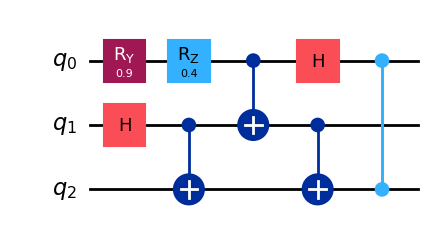

In [7]:
theta, phi = 0.9, 0.4
f_ideal, qc_ideal = ideal_fidelity(theta, phi)
print(f"[Ideal] fidelity = {f_ideal:.6f}")
qc_ideal.draw('mpl')

## 3. ノイズ付きシミュレーション
デポラライジングノイズを導入して、忠実度がどのように低下するかを調べます。

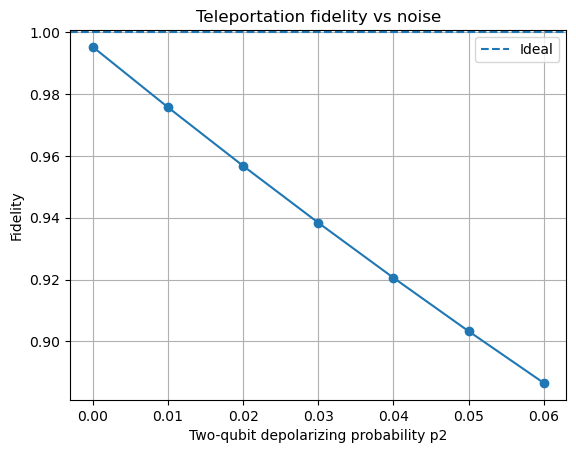

In [8]:
p2_list = np.linspace(0, 0.06, 7)
f_noisy = [noisy_fidelity(theta, phi, p1=0.003, p2=p2) for p2 in p2_list]
plt.plot(p2_list, f_noisy, marker='o')
plt.axhline(f_ideal, linestyle='--', label='Ideal')
plt.xlabel('Two-qubit depolarizing probability p2')
plt.ylabel('Fidelity')
plt.title('Teleportation fidelity vs noise')
plt.legend(); plt.grid(); plt.show()

## 4. 実機実行（IBM Quantum）
以下は実機で実行するためのサンプルコードです。IBMアカウントとAPIトークンが必要です。

In [9]:

# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()
# backend = service.backend("ibmq_manila")  # 実機名
# qc_real = build_teleport_circuit_deferred(theta, phi, measure=True)
# job = service.run(qc_real, backend=backend, shots=4000)
# result = job.result()
# counts = result[0].data.meas.get_counts()
# print(counts)


## 5. 考察と結論
- 理想状態ではfidelity=1に近い結果を得られる。
- ノイズによりfidelityが低下するが、シミュレーションは実機の挙動をよく再現する。
- 実機の実験ではエラー緩和などの技術を使うことで改善が期待できる。